#<FONT COLOR="RED">***Overwiew***</FONT>

---
---


This **Google Colab notebook** is designed to **fine-tune a small language model (SLM)** known as **"Phi-3-mini-4k-instruct"** specifically for **translating intents** from network resources. The goal is to specialize this pre-trained model so that it can respond more effectively and appropriately in conversations where intent translation is needed.

To optimize the results, the training process incorporates the **zero-shot Prompt Engineering technique**.

# <FONT COLOR="ORANGE">**Prepare Notebook**</FONT>

---
---


It's important to note that the notebook is designed to run from **Google Colab** (with free GPU T4 resources), so some packages used aren't installed, as they're included by default in the environment. If you're having issues with any of the packages, we recommend checking your installed versions to install the missing packages in their supported versions.

In [ ]:
# Color messages function
def print_mess(mess:str, color="green") -> None:
  match color:
    case "green":
      print(f"\033[92m{mess}\033[0m")
    case "red":
      print(f"\033[91m{mess}\033[0m")
    case "yellow":
      print(f"\033[93m{mess}\033[0m")
    case "white":
      print(f"\033[97m{mess}\033[0m")


In [ ]:
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.10.10 requires msgspec, which is not installed.
unsloth-zoo 2025.10.10 requires tyro, which is not installed.
unsloth-zoo 2025.10.10 requires torchao>=0.13.0, but you have torchao 0.10.0 which is incompatible.
unsloth-zoo 2025.10.10 requires trl!=0

In [ ]:
# Identify environment keys
import os
import subprocess

# Google Colaboratory environment flag
is_in_Google_Colab = True

In [ ]:
# # Identify environment keys
# import os
# import subprocess

# # Google Colaboratory environment flag
# is_in_Google_Colab = True

# if "COLAB_" not in "".join(os.environ.keys()):
#   is_in_Google_Colab = False
#   print_mess("Notebook is actually running out of Google Colaboratory environment", "yellow")
#   print_mess("Installing necessary packages...", "white")
#   try:
#     # Install unsloth first with its dependencies
#     # subprocess.run([
#     #     "pip", "install",
#     #     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
#     # ])
#     subprocess.run([
#         "pip", "install",
#         "datasets>=3.4.1,<4.0.0", "tqdm",
#     ])
#     print_mess("Packages installed successfully", "green")
#   except Exception as e:
#     print_mess("Something went wrong", "red")
# else:
#   print_mess("Notebook is running in Google Colaboratory environment", "green")
#   print_mess("Installing necessary packages...", "white")
#   try:
#     # Install unsloth first with its dependencies
#     # subprocess.run([
#     #     "pip", "install",
#     #     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
#     # ])

#     subprocess.run([
#         "pip", "install", "--no-deps"
#         "bitsandbytes", "accelerate", "xformers==0.0.29.post3", "peft", "trl<0.9.0",
#         # "triton", "cut_cross_entropy", "unsloth_zoo"
#     ])

#     subprocess.run([
#         "pip", "install",
#         "sentencepiece", "protobuf", "datasets>=3.4.1,<4.0.0",
#         "huggingface_hub>=0.34.0", "hf_transfer"
#     ])

#     # Install other packages
#     subprocess.run([
#         "pip", "install", "--upgrade"
#         "google-api-python-client", "google-auth-httplib2", "google-auth-oauthlib"
#     ])

#     subprocess.run([
#         "pip", "install",
#         "tqdm"
#     ])

#     print_mess("Packages installed successfully", "green")
#   except Exception as e:
#     print_mess("Something went wrong", "red")

In [ ]:
# Fine-tune packages
from unsloth import FastLanguageModel, is_bfloat16_supported, unsloth_train # This import need ve first
import numpy as np
import time
import traceback
import torch
from transformers import TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback, DataCollatorForSeq2Seq
from trl import SFTTrainer, SFTConfig

# Sava model packages
import datetime

# Nootebook visual presentation packages
from tqdm import tqdm

# Dataset packages
import io
import json
from datasets import Dataset
from unsloth.chat_templates import get_chat_template

# Google authentication packages only used in Google Colaboratory environment
if is_in_Google_Colab:
  from google.colab import auth
  from googleapiclient.errors import HttpError
  from googleapiclient.discovery import build
  from googleapiclient.http import MediaIoBaseDownload, MediaIoBaseUpload, MediaFileUpload

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!


If you're using **Google Collaboratory** to run this notebook and don't have the file with the natural language intents and their translations, we recommend mounting the **Google Drive** through the authentication cell.

If you **don't want to allow access to your Google Drive**, we invite you to visit our **[GitHub repository](https://)** where you can find the dataset files to train the model in this notebook.

In [ ]:
# Google connection and authentication
if is_in_Google_Colab:
  auth.authenticate_user()
  drive_service = build("drive", "v3")

Likewise, if you're working in an **environment outside of Google Colaboratory** or have chosen **not to mount your Google Drive** to the Google Colaboratory environment, you must have the train and test dataset files in the same directory for use with this notebook.

In [ ]:
# Here you must put the name of your files with the JSON extension when notebook
# is outside of Google Colaboratory
train_dataset_name = "RMI_Intentions_Train_Dataset.json"
test_dataset_name = "RMI_Intentions_Test_Dataset.json"

In [ ]:
# If notebook is executed from Google Colaboratory, and you want to use the last
# version of the dataset files, it's necessary that mount the Google Drive unit
# and execute the following cells.
if is_in_Google_Colab:
  main_folder_id = "1jDVh28jOvtTU6Wsz_ZhlYrUT1plT9KXb"

  # Search the most recent created folder
  folder_list = drive_service.files().list(
      q=f"'{main_folder_id}' in parents and mimeType = 'application/vnd.google-apps.folder' and name contains 'RMI_Intentions_Dataset_'",
      spaces="drive",
      fields="nextPageToken, files(id, name, createdTime)",
      orderBy="createdTime desc"
  ).execute()

  # Obtain the most recent folder id
  if not folder_list.get("files", []):
    print_mess("No folders found", "red")
  else:
    folder_id = folder_list.get("files", [])[0]["id"]
    print_mess(f"The most recent folder ID is: {folder_id}")

The most recent folder ID is: 1PdTlqDHuvyHNZ0nkKl_JSr3_BFTr3iF8


In [ ]:
# Find datasets inside the Google Drive folder
if is_in_Google_Colab:
  id_dataset = []
  for name_dataset_file in [train_dataset_name, test_dataset_name]:
    dataset_list = drive_service.files().list(
        q = f"'{folder_id}' in parents and name = '{name_dataset_file}'",
        spaces = "drive",
        fields = "nextPageToken, files(id, name)"
    ).execute()

    # Identify item in the result file list
    if not dataset_list.get("files", []):
      print_mess(f"The file '{name_dataset_file}' was not found in the provided folder", "red")
    else:
      id_dataset_file = dataset_list.get("files", [])[0]["id"]
      id_dataset.append(id_dataset_file)
      print_mess(f"The file '{name_dataset_file}' was found with ID: {id_dataset_file}")

The file 'RMI_Intentions_Train_Dataset.json' was found with ID: 12wBcKG5u0U8LE-wQOllStNyblhRjtvdD
The file 'RMI_Intentions_Test_Dataset.json' was found with ID: 1j-GogIOl0CI2PDA65JKjPlG8AkzwUZFC


In [ ]:
# Download function
def download_file(file_id:str, file_name:str) -> str:
  # Request to download file
  request=drive_service.files().get_media(fileId=file_id)
  fh = io.BytesIO()
  downloader = MediaIoBaseDownload(fh, request)
  done = False

  # Download process
  with tqdm(total = 100, unit = "%", desc = f"Downloading {file_name} file") as pbar:
    while done is False:
      status, done = downloader.next_chunk()
      pbar.update(int(status.progress() * 100) - pbar.n)

  # Move the cursor to the beginning for correct reading of the file
  fh.seek(0)
  return fh.read().decode("utf-8")

In [ ]:
# Download txt file in the Google Colaboratoy environment
if is_in_Google_Colab:
  try:
    print_mess("Downloading train and test datasets...", "green")
    print_mess("Downloading train dataset...", "white")
    train_json_dataset = download_file(id_dataset[0], train_dataset_name)
    print_mess("Downloading test dataset...", "white")
    test_json_dataset = download_file(id_dataset[1], test_dataset_name)
    print_mess("\nDatasets downloaded successfully", "green")
  except Exception as e:
    print_mess("Something went wrong", "red")
else:
  try:
    print_mess("Reading train and test datasets...", "green")
    print_mess("Reading train dataset...", "white")
    with open(train_dataset_name, "r") as f:
      train_json_dataset = f.read()
    print_mess("Reading test dataset...", "white")
    with open(test_dataset_name, "r") as f:
      test_json_dataset = f.read()
    print_mess("Datasets read successfully", "green")
  except Exception as e:
    print_mess("Something went wrong", "red")


Datasets downloaded successfully


# <FONT COLOR="ORANGE">**Download and configure Model**</FONT>

---
---


For this project, **we chose to use the Phi-3 model**, specifically its **small language model (SLM) version called "Phi-3-mini-4k-instruct"**, which offers great capabilities as a conversational model and in code generation while consuming minimal resources.

However, we wanted to take its optimization to the next level, so in this section, **with the help of the `unsloth` package**, we used a model previously optimized for this task and **applied the Q-LoRa technique to quantize the model and optimize memory usage**, seeking to achieve the highest possible training quality with the minimum amount of resources possible—in this case, **using only the free T4 GPU resources from Google Colab**.

In [ ]:
# Download Model Parameters
# model_name = "Phi-3-mini-4k-instruct"
model_name = "Phi-3.5-mini-instruct"
sequence_length = 2048
quantization_model = True
seed = 3407

In [ ]:
#Download Model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"unsloth/{model_name}",
    max_seq_length=sequence_length,
    dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16,
    load_in_4bit = quantization_model
)

==((====))==  Unsloth 2025.8.9: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# LoRa Configuration
model = FastLanguageModel.get_peft_model(
    model = model,
    r = 16,
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = 'unsloth',
    random_state = seed,
    use_rslora = False,
    loftq_config = None
)

Unsloth 2025.8.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# <FONT COLOR="ORANGE">**Dataset Preprocessing**</FONT>

---
---


To further **ensure the model correctly understands the training data**, it is important to provide it with said data in a correct format. In this case, since **Phi-3 is a conversational model that uses special tokens to delimit information**, it is important to make conscious use of these tokens, which are:

*   **<|user|>**: Indicates where the input provided by a user begins, i.e., what the model is asked to do.
*   **<|assistant|>**: Indicates where the output it should generate as a conversational assistant model begins, i.e., during training, it teaches it how to respond.
*   **<|end|>**: Indicates to the model where either of the two previous sections ends. This token is essential for the model to understand where what the user says ends and where the assistant should respond.

Seeking to achieve the best possible quality in the responses generated by the model, **we added a custom token to each of the conversations from which the model will learn**, which is:

*   **<|system_message|>**: Through this token, we apply the Prompt Engineering Zero-Shot technique during training to further specialize the model's behavior and obtain the most accurate responses possible.


In [ ]:
# Formatting prompts
def formatting_prompts_func(conversation_dataset):
  convers = conversation_dataset["conversations"]
  prompts = [tokenizer.apply_chat_template(conver, tokenize = False, add_generation_prompt = False) for conver in convers]
  return {"prompts":prompts}

In [ ]:
# Create prompt template
tokenizer = get_chat_template(
  tokenizer,
  chat_template = 'phi-3',
  mapping = {
    'role': 'from',
    'content': 'value',
    'user': 'user_operator',
    'assistant': 'model_answer'
  }
)

In [ ]:
# Create train and test dataset files of type Dataset
print_mess("Creating train and test datasets...", "green")
print_mess("Creating train dataset...", "white")
train_dataset = Dataset.from_dict(json.loads(train_json_dataset))
print(train_dataset)
print_mess("Creating test dataset...", "white")
test_dataset = Dataset.from_dict(json.loads(test_json_dataset))
print(test_dataset)
print_mess("Datasets created successfully", "green")

Creating train and test datasets...
Creating train dataset...
Dataset({
    features: ['conversations'],
    num_rows: 242
})
Creating test dataset...
Dataset({
    features: ['conversations'],
    num_rows: 81
})
Datasets created successfully


In [ ]:
# Apply Phi 3 template
try:
  print_mess("Applying template to datasets...", "green")
  print_mess("Formatting train dataset...", "white")
  train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
  print_mess("Formatting test dataset...", "white")
  test_dataset = test_dataset.map(formatting_prompts_func, batched=True)
  print_mess("Template applied successfully", "green")
except Exception as e:
  print_mess("Something went wrong", "red")

Applying template to datasets...
Formatting train dataset...


Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Formatting test dataset...


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Template applied successfully


# <FONT COLOR="ORANGE">**Training Model Configuration**</FONT>

---
---


Due to the **limited use of Google Colab's free T4 GPU resources**, the parameters were determined through **trial and error**, seeking to avoid overfitting, underfitting, and hallucinations in each iteration. These conditions, if not handled carefully, greatly affect the quality of the responses generated by the model.

In [ ]:
# Argument Configuration
training_args = SFTConfig(
    dataset_text_field = "prompts",
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 2,
    warmup_steps = 5,
    max_steps = 100,
    learning_rate = 0.5e-4,
    logging_steps = 1,
    eval_strategy = "steps",
    eval_steps = 1,
    # save_strategy = "steps",
    # save_steps = 5,
    # save_total_limit=5,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = seed,
    output_dir = "outputs",
    report_to = "none",
    # dataset_text_field = "prompts",
    # per_device_train_batch_size = 8,
    # per_device_eval_batch_size = 8,
    # gradient_accumulation_steps = 4,
    # warmup_steps = 10,
    # max_steps = 150,
    # learning_rate = 0.5e-4,
    # logging_steps = 5,
    # optim = "adamw_8bit",
    # weight_decay = 0.05,
    # lr_scheduler_type = "linear",
    # seed = seed,
    # eval_strategy = "steps",
    # eval_steps = 5,
    # save_strategy = "steps",
    # save_steps = 5,
    # save_total_limit=4,
    # output_dir="outputs",
    # report_to = "none",
    # fp16 = not is_bfloat16_supported(),
    # bf16 = is_bfloat16_supported(),
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
)

In [ ]:
# Trainer Configuration
# early_stopping_callback = EarlyStoppingCallback(
#     early_stopping_patience=5,
#     early_stopping_threshold=0.0001
# )

trainer = SFTTrainer(
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    max_seq_length = sequence_length,
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    args=training_args,
    callbacks=[early_stopping_callback],
)

Unsloth: Tokenizing ["prompts"] (num_proc=2):   0%|          | 0/242 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["prompts"] (num_proc=2):   0%|          | 0/81 [00:00<?, ? examples/s]

# <FONT COLOR="ORANGE">**Train Model**</FONT>

---
---


Once the **dataset and parameters for model training have been prepared**, it is time to apply the **fine-tune technique to SLM Phi 3** to obtain a model capable of receiving a network resource management intention described in natural language and transforming it into a network resource management intention described in the RDF turtle format according to the TM Forum specifications.

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
14.533 GB of memory reserved.


In [ ]:
print_mess("Training model in progress...", "green")
try:
  start_time = time.time()
  trainer_stats = unsloth_train(trainer)
  training_time = time.time() - start_time
  print_mess(f"Training time: {training_time:.2f} seconds", "green")
except Exception as e:
  print_mess("Something went wrong", "red")
  print(e)

Training model in progress...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 242 | Num Epochs = 4 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 29,884,416 of 3,850,963,968 (0.78% trained)


Step,Training Loss,Validation Loss
1,0.774600,0.685927
2,0.746400,0.678604
3,0.622200,0.665560
4,0.647700,0.648853
5,0.668800,0.625497
6,0.648100,0.593769
7,0.611600,0.564024
8,0.592600,0.534754
9,0.488600,0.504122
10,0.475000,0.473933


Step,Training Loss,Validation Loss
1,0.774600,0.685927
2,0.746400,0.678604
3,0.622200,0.665560
4,0.647700,0.648853
5,0.668800,0.625497
6,0.648100,0.593769
7,0.611600,0.564024
8,0.592600,0.534754
9,0.488600,0.504122
10,0.475000,0.473933


Training time: 7756.44 seconds


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

7752.9323 seconds used for training.
129.22 minutes used for training.
Peak reserved memory = 14.533 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 98.589 %.
Peak reserved memory for training % of max memory = 0.0 %.


# <FONT COLOR="ORANGE">**Save Model**</FONT>

---
---


Once the model is tuned, given that the free and limited resources of Google Colab of T4 GPU are being used, it is necessary to save the results obtained. The following section of code is responsible for generating files that can be downloaded from the Google Colab environment. If you have mounted Google Drive, you can also replace the ID of the main folder to store these files within your Google Drive.

In [ ]:
# Save file parameters
def gen_parameters() -> list:
  execution_date = datetime.datetime.now()
  execution_date = execution_date.strftime("%Y%m%d_%H%M%S")
  save_name_folder = f"Translation_Intent_Model_{execution_date}"
  if is_in_Google_Colab:
    save_folder_path = "1Sa_l3z1nPgOPYeucudci3je5rjTRTH1g"
  else:
    save_folder_path = "Model_Versions"

  return [save_name_folder, save_folder_path]

In [ ]:
# Create folder function
def create_folder() -> str:
  # Generate folder parameters
  [folder_name, folder_path] = gen_parameters()

  print_mess("Creating folder...", "green")
  if is_in_Google_Colab:
    try:
      folder_metadata = {
          "name": folder_name,
          "mimeType": "application/vnd.google-apps.folder",
          "parents": [folder_path]
      }
      folder = drive_service.files().create(
          body = folder_metadata,
          fields = "id"
      ).execute()
      print_mess(f"Folder '{folder_name}' created correctly with ID: {folder.get('id')}", "green")

      return folder.get("id")
    except HttpError as e:
      print_mess("Something went wrong", "red")
      return ""
  else:
    try:
      folder_path = os.path.join(folder_path, folder_name)
      if not os.path.exists(folder_path):
        os.makedirs(folder_path)
      print_mess(f"Folder '{folder_name}' created correctly", "green")

      return os.path.join(folder_path, folder_name)
    except Exception as e:
      print_mess("Something went wrong", "red")
      return ""

In [ ]:
def save_model_files(model_output_dir, folder_id):
  for filename in os.listdir(model_output_dir):
    filepath = os.path.join(model_output_dir, filename)
    if os.path.isfile(filepath):
      file_metadata = {
          'name': filename,
          'parents': [folder_id]
      }
      media = MediaFileUpload(filepath, mimetype='application/octet-stream')
      file = drive_service.files().create(
              body=file_metadata,
              media_body=media,
              fields='id').execute()
      print_mess(f"File '{filename}' uploaded to Google Drive with ID: {file.get('id')}", "green")

In [ ]:
# Save model in environment
print_mess("Saving model in environment...", "yellow")
folder_id = create_folder()
output_dir = "model_trained"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print_mess("Model saved successfully in environment directory", "yellow")

Saving model in environment...
Creating folder...
Folder 'Translation_Intent_Model_20250828_024842' created correctly with ID: 1fuvIXHhbG1p-ChFL0ZxchmnDp-5XQK8R
Model saved successfully in environment directory


In [ ]:
# Save model in Google Drive Unit
if is_in_Google_Colab:
  print_mess("Saving model in Google Drive Unit...", "green")
  try:
    print_mess("Uploading model files...", "white")
    save_model_files(output_dir, folder_id)
    print_mess("Model files saved successfully", "green")
  except Exception as e:
    print_mess("Something went wrong", "red")

Saving model in Google Drive Unit...
Uploading model files...
File 'README.md' uploaded to Google Drive with ID: 1LBFBfR_k-pA4aTiP9hCNQEZuJcQigjbn
File 'chat_template.jinja' uploaded to Google Drive with ID: 1feSUCbFYseiDsGM0KyO1UNXSSGGnKclg
File 'adapter_model.safetensors' uploaded to Google Drive with ID: 1qQDDz06F18jklsahy21WwoCM1LTWGH18
File 'tokenizer.json' uploaded to Google Drive with ID: 1vIutXgjUK79YfFxpIbRba8sIKKnYwDpx
File 'tokenizer.model' uploaded to Google Drive with ID: 19uTv8IouYD9QemSSr46k7GZcuhNithF-
File 'tokenizer_config.json' uploaded to Google Drive with ID: 1wpsH3PNh5t4U1Rcy01AMtbPN40rVlvIq
File 'added_tokens.json' uploaded to Google Drive with ID: 1C5Ih5Be8oFRp5lbmljDpWKvXhD1ZQrix
File 'special_tokens_map.json' uploaded to Google Drive with ID: 11Eup7LlC879_GM12L5Vs8GKeP5bQkC0s
File 'adapter_config.json' uploaded to Google Drive with ID: 1zxV_JYA7oJScti9XsrnFdPXhZTgU8aye
Model files saved successfully


In [ ]:
# NOTA: LOS SIGUIENTES MODELOS ENTREGAN TRADUCCIONES.
# Translation_Intent_Model_20250802_232112 (La traducción es demasiado mala)

Último modelo entrenado:

# Translation_Intent_Model_20250807_025434

## Configuración de Parámetros
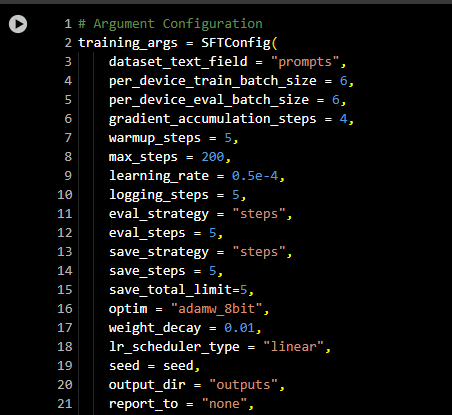

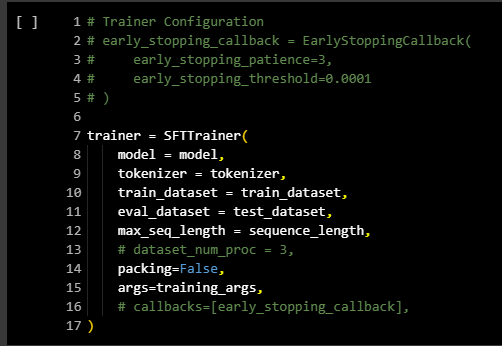

## Resultados de Entrenamiento

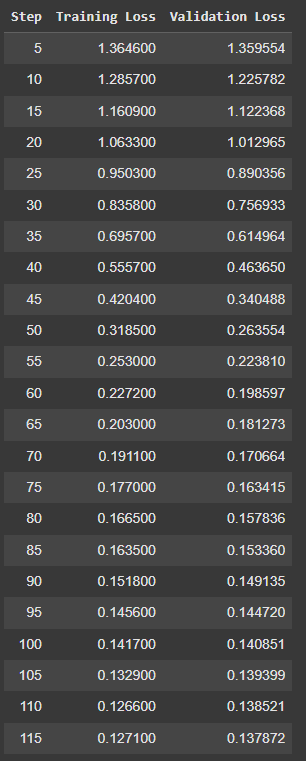

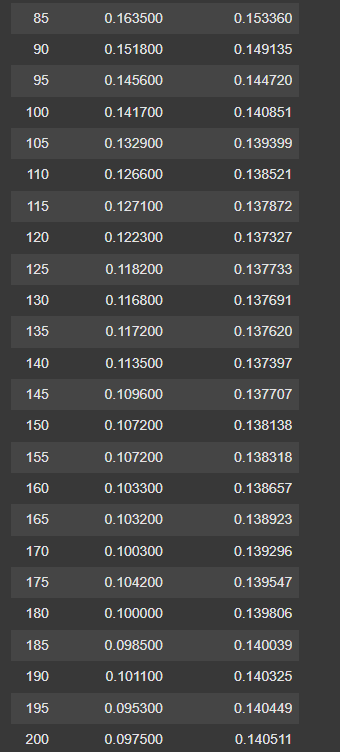

# Translation_Intent_Model_20250804_181852

## Configuración de Parametros
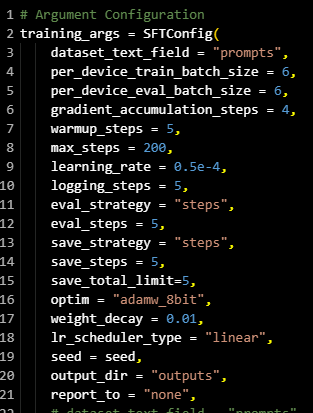

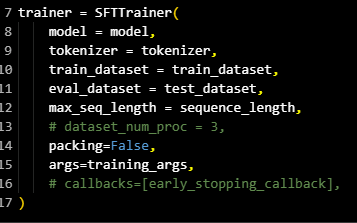

## Resultados de entrenamiento

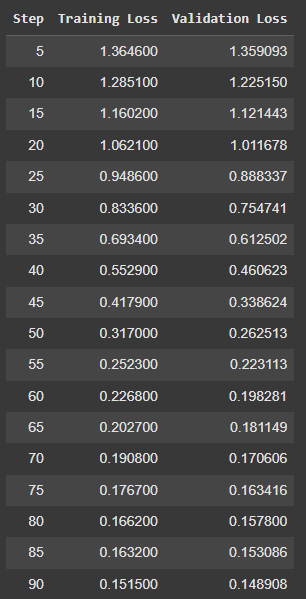

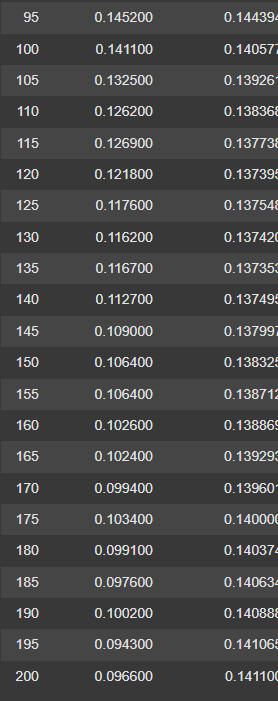